In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import math
import os
import collections
import pickle

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from pymir import mpl_stylesheet
from pymir import mpl_utils
from pymir import pd_utils

mpl_stylesheet.banskt_presentation(splinecolor = 'black', dpi = 300)

## Local imports
import methodprops

In [2]:
dscout = pd.read_pickle("../dsc/results/linreg_corr_dscout.pkl")
plotfilename = "linreg_corr_rmse_comparison"

In [3]:
# methods in the simulation

dims = [(50, 10000),]
sfixs = [1, 2, 5, 10, 20,]
method_groups = {
    'PLR': ["ridge", "lasso", "elastic_net", 
            "lasso_1se", "elastic_net_1se", 
            "scad", "mcp", "l0learn"],
    'Sampling': ["blasso", "bayesb"],
    'CAVI': ["mr_ash", "mr_ash_lasso_init", "varbvs", "varbvsmix", "susie"],
    'GradVI': ["gradvi_direct", "gradvi_compound"],
}

In [4]:
# method_groups = {
#     'PLR': ["ridge", "lasso"],
#     'CAVI': ["mr_ash",],
#     'GradVI': ["gradvi_direct", "gradvi_compound"],
# }

method_groups = {
    'PLR': ["lasso", "elastic_net", 
            "lasso_1se", "elastic_net_1se", 
            "scad", "mcp", "l0learn"],
    'Sampling': ["bayesb"],
    'CAVI': ["mr_ash", "mr_ash_lasso_init", "varbvs", "varbvsmix"],
    'GradVI': ["gradvi_direct", "gradvi_compound"],
}

methods = [method for k, v in method_groups.items() for method in v]

In [5]:
dscout

,DSC,simulate,simulate.dims,simulate.se,simulate.rholist,simulate.sfix,simulate.pve,fit,fit.DSC_TIME,mse.err,coef_mse.err
0,1,blockdiag,"(500,10000)",0.967784,"(0.9,0.9,0.9)",5,0.6,susie,64.898,0.980076,NaN
1,1,blockdiag,"(500,10000)",2.931741,"(0.9,0.9,0.9)",20,0.6,susie,88.383,9.753106,NaN
2,2,blockdiag,"(500,10000)",2.356556,"(0.9,0.9,0.9)",5,0.6,susie,74.155,6.502357,NaN
3,2,blockdiag,"(500,10000)",3.905370,"(0.9,0.9,0.9)",20,0.6,susie,46.692,19.290065,NaN
4,3,blockdiag,"(500,10000)",2.638768,"(0.9,0.9,0.9)",5,0.6,susie,269.852,6.798610,NaN
...,...,...,...,...,...,...,...,...,...,...,...
675,8,blockdiag,"(500,10000)",2.760648,"(0.9,0.9,0.9)",20,0.6,l0learn,5.762,NaN,0.001938
676,9,blockdiag,"(500,10000)",2.706186,"(0.9,0.9,0.9)",5,0.6,l0learn,4.176,NaN,0.000400
677,9,blockdiag,"(500,10000)",2.269563,"(0.9,0.9,0.9)",20,0.6,l0learn,5.660,NaN,0.001987
678,10,blockdiag,"(500,10000)",1.291318,"(0.9,0.9,0.9)",5,0.6,l0learn,14.281,NaN,0.000173


In [6]:
def saveplot(fig, fileprefix, plotdir = "."):
    for ext in ['pdf', 'png']:
        fl = f"{plotdir}/{fileprefix}.{ext}"
        fig.savefig(fl, bbox_inches = 'tight')
    return

class PlotInfo(collections.namedtuple('PLOT_FIELDS', 
               ['color', 'label', 'marker', 'size'])):
    __slots__ = ()
    
class LabelInfo(collections.namedtuple('LABEL_FIELDS', 
               ['color', 'label'])):
    __slots__ = ()
    
def stratify_dfcol(df, colname, value):
    return df.loc[df[colname] == value]

def scaled_rmse(mse, std, pve, n = 1000):
    rmse = np.sqrt(np.array(mse)) / np.sqrt(n)
    scale = np.array(std) / np.sqrt(1 - np.array(pve))
    return rmse / scale

def score_factory(df, method = 'scaled_rmse', ntest = 1000):
    if method == 'scaled_rmse':
        dfs = df[~df['mse.err'].isnull()]
        score = scaled_rmse(dfs['mse.err'], dfs['simulate.se'], dfs['simulate.pve'])
        return score
    elif method == 'scaled_coef_rmse':
        dfs = df[~df['coef_mse.err'].isnull()]
        score = np.sqrt(dfs['coef_mse.err'].to_numpy()) #/ np.sqrt(ntest)
        return score
    return np.array([0.])
    
sfix_props = {
    1  : PlotInfo(color = '#93AA00', label = '1',  marker = '^', size = 1.1),
    2  : PlotInfo(color = '#2D69C4', label = '2',  marker = 'v', size = 1),
    5  : PlotInfo(color = '#FFB300', label = '5',  marker = 'o', size = 1.2),
    10 : PlotInfo(color = '#CC2529', label = '10', marker = 's', size = 1.2),
    20 : PlotInfo(color = '#6B4C9A', label = '20', marker = 'D', size = 1)
}

group_props = {
    'PLR'      : LabelInfo(color = '#803E75', label = 'PLR'), 
    'Sampling' : LabelInfo(color = '#FF8E00', label = 'Sampling'), 
    'CAVI'     : LabelInfo(color = '#817066', label = 'CAVI'), 
    'GradVI'   : LabelInfo(color = '#C10020', label = 'GradVI')
}

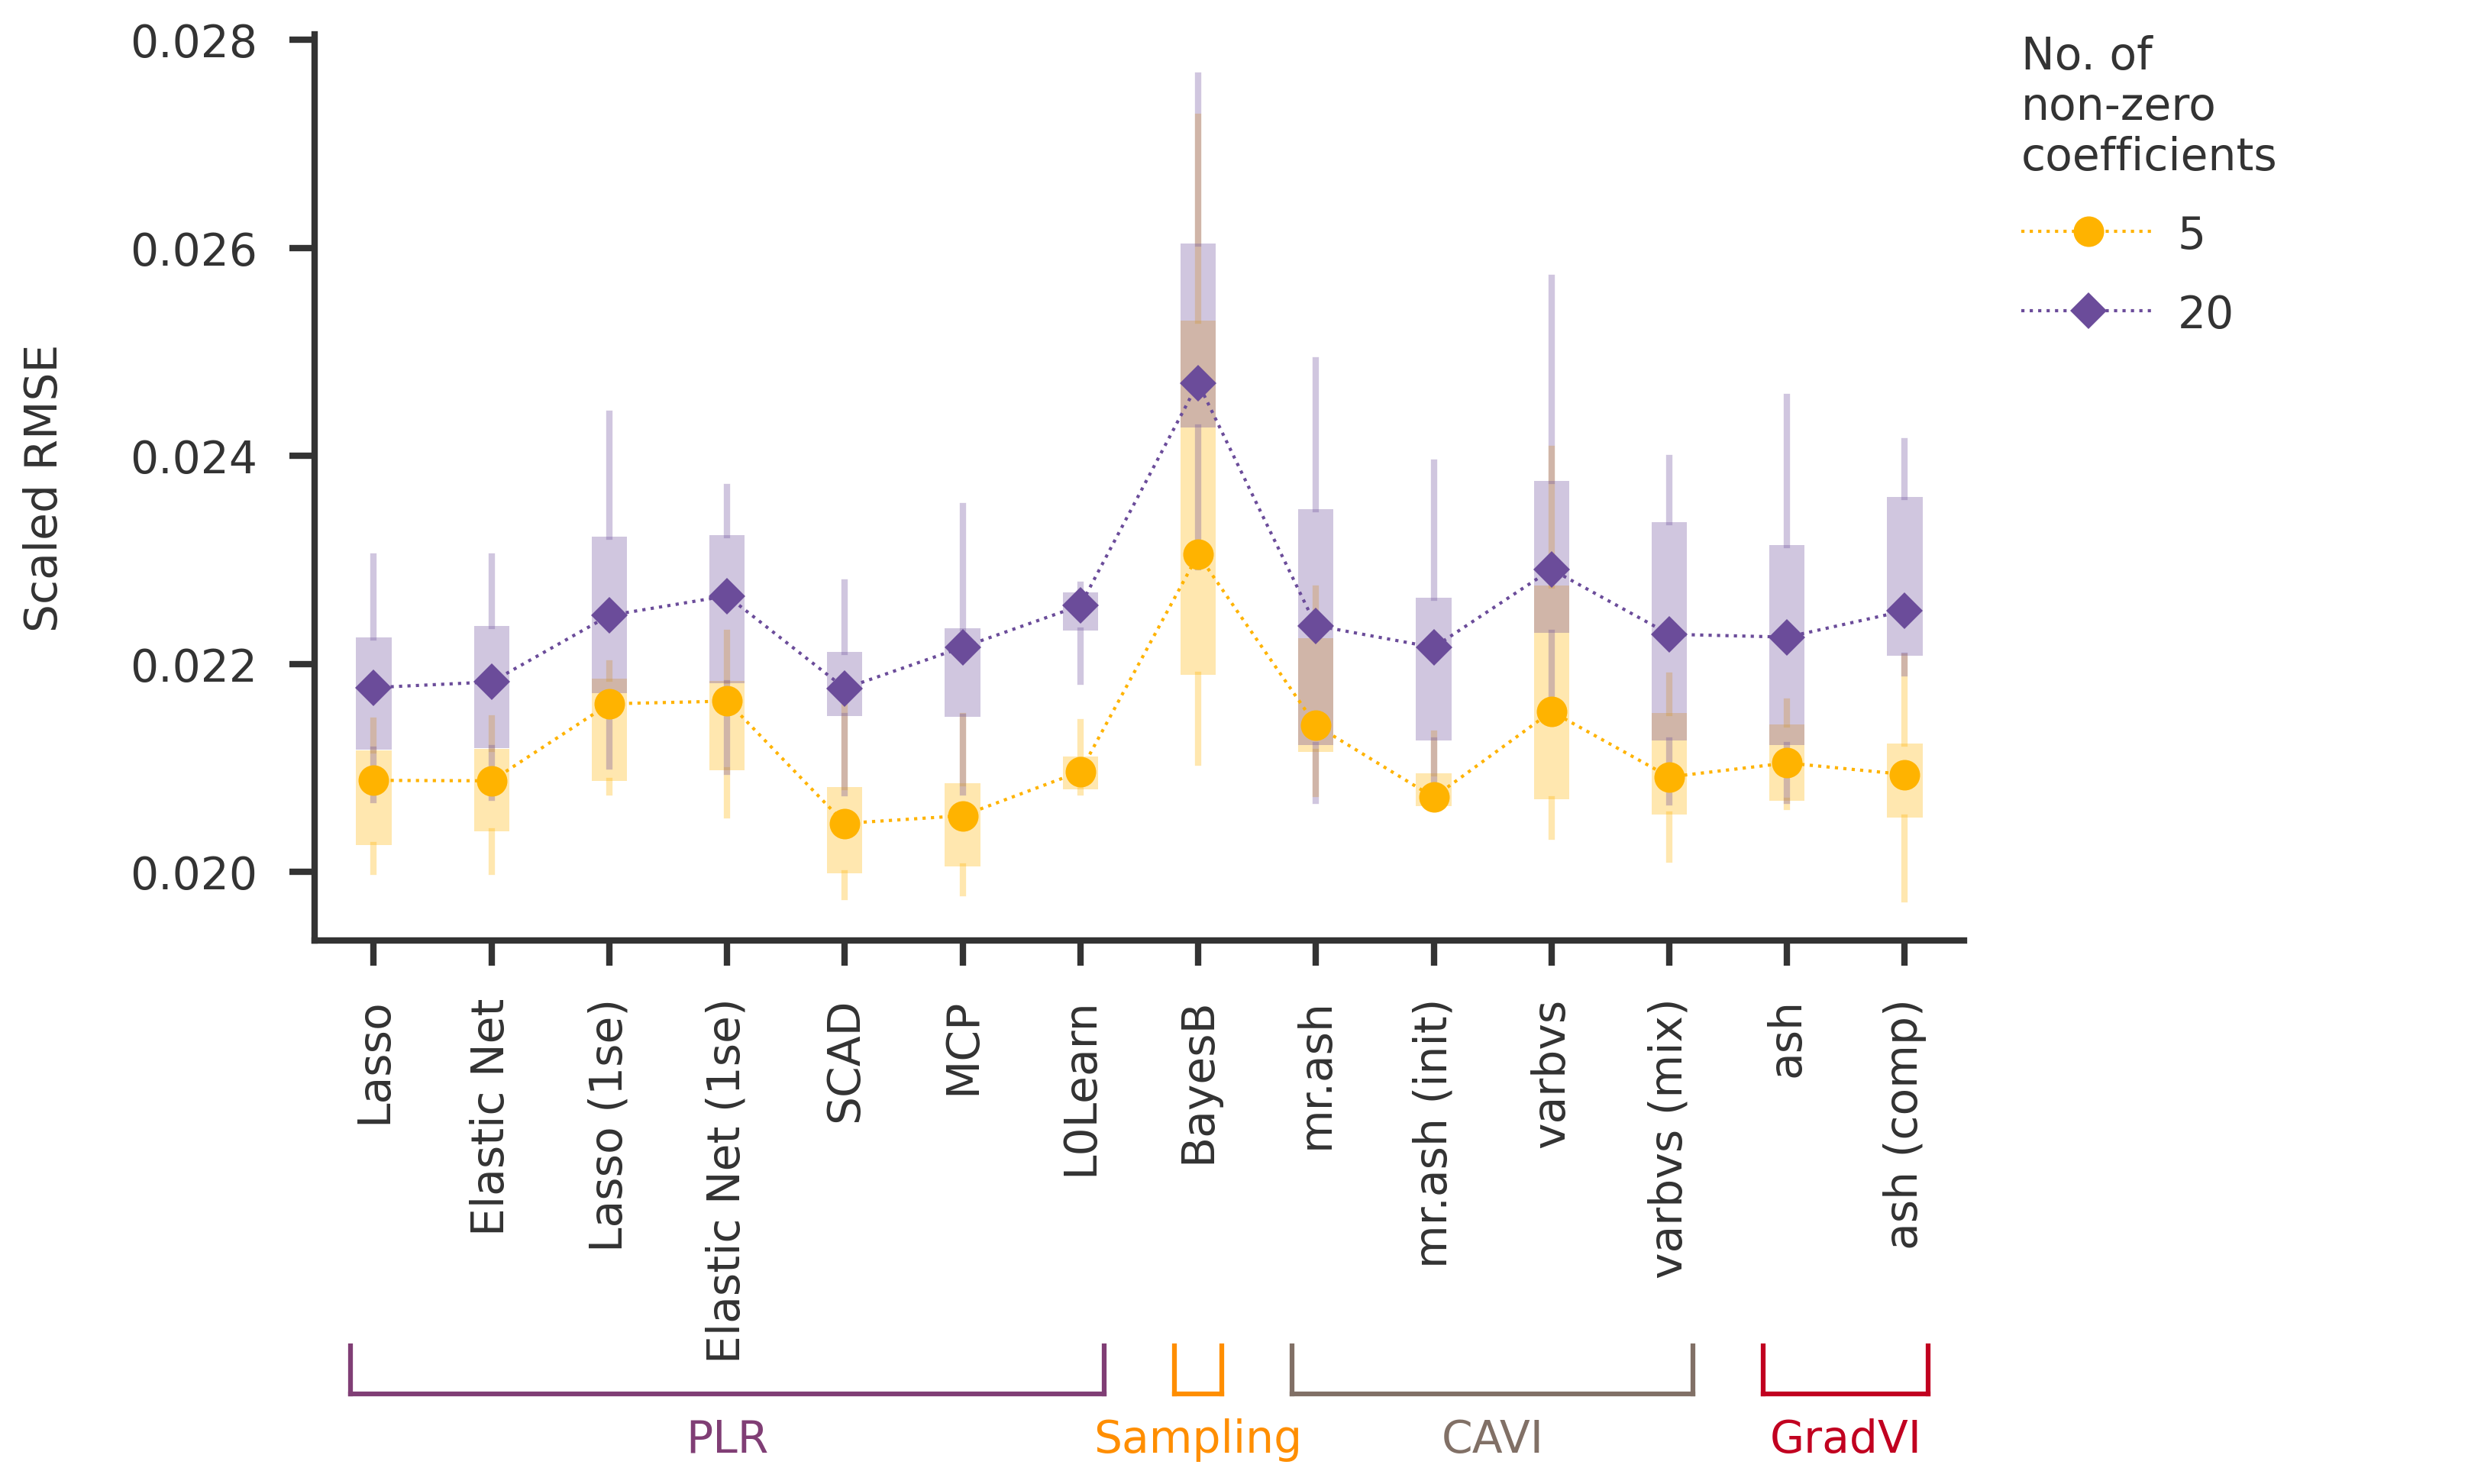

In [7]:

figw = 12
figh = 8
debugmode = False
savemode  = True
showfliers = False
showboxplot = True
showgrid = False
yscale = 'linear'

fig = plt.figure(figsize = (figw, figh))
#axdummy = fig.add_subplot(111)
#ax1     = fig.add_subplot(111)
gs      = fig.add_gridspec(ncols = 2, nrows = 2, width_ratios = [3.5, 1], height_ratios = [1.9, 1])
gs.update(wspace = 0.01, hspace = 0.0) # set the spacing between axes. 
ax2 = fig.add_subplot(gs[1, 0])
ax1 = fig.add_subplot(gs[0, 0])
leg_ax = fig.add_subplot(gs[:, 1])

resdf = stratify_dfcol(dscout, 'simulate.pve', 0.6)

#for i, s in enumerate(sfixs):
for i, s in enumerate([5, 20]):
    pinfo = sfix_props[s]
    dfm = stratify_dfcol(resdf, 'simulate.sfix', s)
    
    # boxplot input x
    # If a 2D array, a boxplot is drawn for each column in x. 
    # If a sequence of 1D arrays, a boxplot is drawn for each array in x.
    scores = np.array([score_factory(stratify_dfcol(dfm, 'fit', method)) for method in methods]).T
    
    # Marker and dotted line for the median score of each method
    ax1.plot(
        np.arange(len(methods)), 
        mpl_utils.scale_array(np.median(scores, axis = 0), yscale), 
        label = pinfo.label, color = pinfo.color, lw = 1, 
        ls = 'dotted', marker = pinfo.marker, ms = pinfo.size * 8,
        mec = pinfo.color, mfc = pinfo.color, mew = 0,
        zorder = (i + 1) * 10)
    
    if showgrid:
        median_scores = mpl_utils.scale_array(np.median(scores, axis = 0), yscale)
        ax1.axhline(y = median_scores[-2],
                    zorder = 0, lw = 1, color = 'gainsboro')
    
    # Box plot for each method
    if showboxplot:
        boxcolor = pinfo.color
        boxface = f'#{boxcolor[1:]}50' #https://stackoverflow.com/questions/15852122/hex-transparency-in-colors
        medianprops = dict(linewidth=0, color = boxcolor)
        whiskerprops = dict(linewidth=2, color = boxface)
        boxprops = dict(linewidth=0, color = boxface, facecolor = boxface)
        flierprops = dict(marker='o', markerfacecolor=boxface, markersize=3, markeredgecolor = boxcolor)

        ax1.boxplot(mpl_utils.scale_array(scores, yscale), 
                    positions = np.arange(len(methods)),
                    showcaps = False, showfliers = showfliers, 
                    widths = 0.3, patch_artist = True, notch = False,
                    zorder = (i + 1),
                    flierprops = flierprops, boxprops = boxprops, 
                    medianprops = medianprops, whiskerprops = whiskerprops)

    
    
ax1.set_xticks(np.arange(len(methods)))
mpl_utils.set_yticks(ax1, scale = yscale, spacing = 'linear', fmt = '{:.3f}')

method_labels = [methodprops.plot_metainfo()[x].label for x in methods]
ax1.set_xticklabels(method_labels)
for tick in ax1.get_xticklabels():
    tick.set_rotation(90)
    #tick.set_ha('right')
ax1.set_ylabel("Scaled RMSE")
    
    
# Remove all axis labels and ticks from the spaceholder axes
for ax in [ax2, leg_ax]:
    ax.tick_params(bottom = False, top = False, left = False, right = False,
                   labelbottom = False, labeltop = False, labelleft = False, labelright = False)

if not debugmode:
    # remove borders of helper axes (xr)
    for side, border in list(ax2.spines.items()) + \
                        list(leg_ax.spines.items()):
        border.set_visible(False)
        
    for side, border in list(ax1.spines.items()):
        if side in ['top', 'right']:
            border.set_visible(False)

    # make plots transparent
    for ax in [ax1, ax2, leg_ax]:
        ax.set_facecolor('None')
else:
    fig.set_facecolor('turquoise')
    for ax in [ax1, ax2, leg_ax]:
        ax.set_facecolor('beige')
        

# # Using bottom fancy axes
ax2.set_xlim(ax1.get_xlim())
ax2.set_ylim(0, 1)

gticks = []
gseps = []
gticklabels = []
for key, values in method_groups.items():
    indices = [methods.index(v) for v in values]
    imin = min(indices)
    imax = max(indices)
    gticks.append((imin + imax) / 2.)
    gticklabels.append(key)
    gseps.append((imin, imax))
    y0 = 0.05
    xeps = 0.2
    gcolor = group_props[key].color
    ax2.plot([imin - xeps, imax + xeps], [y0, y0], color = gcolor)
    ax2.axvline(x = imin - xeps, ymin = y0, ymax = y0 + 0.1, color = gcolor)
    ax2.axvline(x = imax + xeps, ymin = y0, ymax = y0 + 0.1, color = gcolor)
    ax2.text((imin + imax) / 2, y0 - 0.05, key, 
             ha = 'center', va = 'top', color = gcolor)

# Legend
mhandles, mlabels = ax1.get_legend_handles_labels()
legend = leg_ax.legend(
    handles = mhandles, labels = mlabels, title = 'No. of\nnon-zero\ncoefficients',
    handlelength = 3, numpoints = 1,
    title_fontproperties={'weight':'normal'},
    loc = 'upper left', bbox_to_anchor = (0.1, 1.0),
    frameon = False, framealpha = 1.0, borderpad = 0.0, borderaxespad = 0.0)
legend._legend_box.align = "left"

if not debugmode:
    if savemode: saveplot(fig, plotfilename)

plt.show()